# 実データ1
National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset

In [12]:
import japanize_matplotlib  # noqa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # データ可視化ライブラリ
from lightning.pytorch import seed_everything
from sklearn.decomposition import PCA

plt.style.use("ggplot")
seed_everything(8)

Seed set to 8


8

# データの前処理

In [13]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
import pandas as pd


df = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\オンラインデータ\NHANES_age_prediction.csv"
)
df = df.drop(columns=["SEQN", "age_group"])

obj = "BMXBMI"
features_list = [
    "RIDAGEYR",  # 年齢（連続変数）
    "RIAGENDR",  # 性別（1:Male, 2:Female)
    "PAQ605",  # 運動有無(1:日常的に運動する, 2:運動しない)
    "LBXGLU",  # 断食後の血糖値（連続変数）
    "DIQ010",  # 糖尿病の有無(0:なし、1:あり)
    "LBXGLT",  # 口内の健康状態（連続変数）
    "LBXIN",  # 血中インスリン濃度（連続変数）
]


# 外れ値の除去
# def remove_outliers_zscore(data, metric, threshold=2):
#   z_scores = np.abs(stats.zscore(data[metric]))
#  data = data[(z_scores < threshold)]
# return data


# df = remove_outliers_zscore(df, obj)

# process_features
from sklearn.preprocessing import StandardScaler
import pandas as pd

X = df[features_list]
# 数値列の標準化
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

X_scaled = pd.DataFrame(scaled_features, columns=features_list)
y = df[obj]  # 目的変数

# 行を詰める
df = df.reset_index(drop=True)

print(df)

      RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  LBXGLT  LBXIN
0         61.0       2.0     2.0    35.7   110.0     2.0   150.0  14.91
1         26.0       2.0     2.0    20.3    89.0     2.0    80.0   3.85
2         16.0       1.0     2.0    23.2    89.0     2.0    68.0   6.14
3         32.0       1.0     2.0    28.9   104.0     2.0    84.0  16.15
4         38.0       2.0     1.0    35.9   103.0     2.0    81.0  10.92
...        ...       ...     ...     ...     ...     ...     ...    ...
2273      38.0       2.0     2.0    33.5   100.0     2.0    73.0   6.53
2274      61.0       1.0     2.0    30.0    93.0     2.0   208.0  13.02
2275      34.0       1.0     2.0    23.7   103.0     2.0   124.0  21.41
2276      60.0       2.0     2.0    27.4    90.0     2.0   108.0   4.99
2277      26.0       1.0     2.0    24.5   108.0     2.0   108.0   3.76

[2278 rows x 8 columns]


# クラスタリング

##### Kmeans

In [14]:
from sklearn.cluster import KMeans

clusters = 5
cluster_labels = [a for a in range(clusters)]


# dataに対してKmeansを行った結果をdataに反映（クラスラベルを追加）する関数
def kmeans_cluster(data, cluster_num):
    # k-meansクラスタリングの適用
    kmeans = KMeans(n_clusters=cluster_num, init="k-means++", random_state=42)
    clusters = kmeans.fit_predict(data)
    # 結果を元のデータフレームに追加
    data["kmeans_cluster"] = clusters
    return data


Kresult = kmeans_cluster(X_scaled, clusters)

N = []
for a in range(clusters):
    cluster_a_list = Kresult[Kresult["kmeans_cluster"] == a]
    N.append(len(cluster_a_list))
print("各クラスタのデータ数:", N)
print(sum(N))

各クラスタのデータ数: [58, 183, 384, 922, 731]
2278


## データの分布を確認

各主成分の説明分散比率:
[0.28910429 0.168583  ]


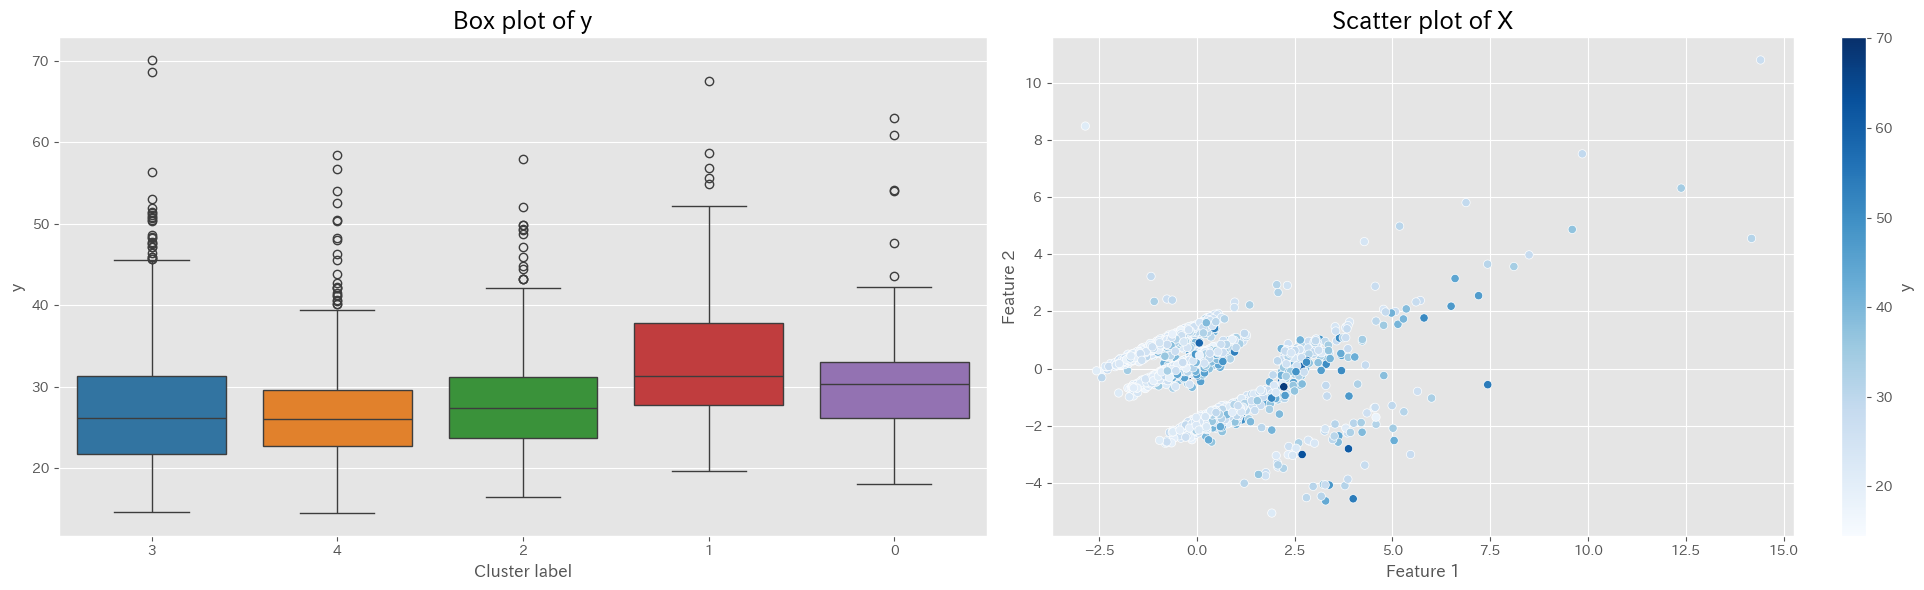

In [15]:
# 目的変数の分布
axes: list[plt.Axes]
fig, axes = plt.subplots(
    1, 2, figsize=(10 * 2, 6 * 1)
)  # 1行2列のサブプロット（横幅20, 縦幅6）
sns.boxplot(  # 箱ひげ図
    x=Kresult["kmeans_cluster"].astype(str),  # x軸、as.type(str)で文字列に変換
    y=y,  # y軸
    ax=axes[0],  # グラフを描画するサブプロット指定
    hue=Kresult["kmeans_cluster"].astype(str),  # クラスタラベルに基づいて色を付ける
    palette="tab10",  # カラーパレット指定
    legend=False,
)
axes[0].set_title("Box plot of y", fontdict={"fontsize": "xx-large"})
axes[0].set_xlabel("Cluster label")
axes[0].set_ylabel("y")

# データの散布図
## 次元削減
pca = PCA(n_components=2)  # 主成分分析で2次元に削減
X_pca = pca.fit_transform(X_scaled)  # XにPCAを適用
# 散布図（x軸：第1主成分、y軸：第2主成分、色分けのためにyを指定、サブプロット、色パレット、凡例）
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=y,
    ax=axes[1],
    palette="Blues",
    legend=False,
)
axes[1].set_title("Scatter plot of X", fontdict={"fontsize": "xx-large"})
axes[1].set_xlabel("Feature 1")
axes[1].set_ylabel("Feature 2")
## colorbar（右のバー）
# カラーバーを作成するためのオブジェクト作成（カラーマップ指定、yの最小値から最大値を正規化）
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=y.min(), vmax=y.max()))
sm._A = []  # smの内部のデータをクリア
cbar = fig.colorbar(sm, ax=axes[1])
cbar.set_label("y")

fig.tight_layout()

explained_variance_ratio = pca.explained_variance_ratio_
print("各主成分の説明分散比率:")
print(explained_variance_ratio)

# 標本戦略の実装

##### 準備：基底クラス
インターフェースを統一するための基底クラスを作成

【ABCMeta】  
・抽象基底クラス（ABC）を定義するためのメタクラス  
・自体のインスタンス化はできないが、サブクラスは実装する必要のある共通のインターフェースを定義できる  
・ABCMeta を使用することで@abstractmethod デコレータを使ってABCを作成できる  
・デコレータ：関数やメソッドを引数として受け取り、修飾した新しい関数やメソッドを返す高階関数 

【abstractmethod】  
・ABC内で抽象メゾッドを定義するために使用される  
・ABCのサブクラスはこれらの抽象メゾッドを実装する必要がある

In [16]:
from abc import ABCMeta, abstractmethod

from numpy.typing import NDArray


class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(self, n_samples: int, H: int, random_state: int):
        self.n_samples = n_samples
        self.H = H
        self.random_state = random_state

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        """クラスタリングを行う

        Args:
            X (NDArray): データ (N x M)

        Returns:
            NDArray: クラスタラベル (N, ), クラスタサイズ (H, )

        Note:
            N: データ数
            M: 特徴量数
            H: クラスタ数
        """
        # kmeans:KMeansを用いてself.H個のクラスタに分割する
        kmeans = KMeans(n_clusters=self.H, random_state=self.random_state)
        # XをKMeansを用いてself.H個のクラスタに分割し、各データのクラスタラベル取得
        cluster_label = kmeans.fit_predict(X)
        # 母集団の各クラスタのサイズを計算
        _, cluster_size = np.unique(cluster_label, return_counts=True)
        # インスタンス変数として設定
        self.cluster_label = cluster_label
        self.N = cluster_size
        return cluster_label, cluster_size.copy()

##### 方法① 単純無作為抽出

In [17]:
from numpy.typing import NDArray


# BaseAllocationを継承することでBaseAllocationクラスで定義されたインスタンス変数やメゾッドを利用できる
class RandomAllocation(BaseAllocation):
    # 抽象メゾッドを具象化
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.n_samples])

        return n  # （例）n=[標本サイズ]

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        # cluster_labelのすべての要素は0（すべてのデータを同じクラスタに属させている）
        cluster_label = np.zeros(
            X.shape[0]
        )  # cluster_label = [0,0,0,,...(要素数：データ数）]
        # クラスタサイズ＝データ数
        cluster_size = np.array([len(cluster_label)])  # cluster_size=[データ数]
        return cluster_label, cluster_size

##### 方法② 比例配分

In [18]:
class PropotionalAllocation(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.n_samples).astype(int)

        if n.sum() > self.n_samples:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.n_samples

        return n

##### 方法③　事後層化

In [19]:
class PostStratification(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.n_samples])

        return n  # （例）n=[標本サイズ]

##### 方法③ 最適配分

In [20]:
from typing import Literal, Optional

from numpy.typing import NDArray


class OptimalAllocation(BaseAllocation):
    def __init__(
        self,
        n_samples: int,
        H: int,
        m: NDArray,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
        random_state: int = 0,
    ):
        super().__init__(
            n_samples, H, random_state
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.m = m  # 各クラスタの最小標本サイズ (H, )
        self.M = M  # 各クラスタの最大標本サイズ (H, ), (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in range(self.H)])
        d = (self.N**2) * S  # (H, )
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N.copy()
        I = np.arange(self.H)  # noqa #クラスタのインデックス
        while (n.sum() != self.n_samples) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.n_samples
        ), f"Total sample size is over than {self.n_samples}"
        assert np.all(n >= self.m), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"

# 比較実験

In [21]:
import numpy as np
from numpy.typing import NDArray


def estimate_y_mean(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    """実際にサンプリングを行って目的変数の平均を推定

    Args:
        n (NDArray): 各クラスタの標本数 (H, )
        cluster_label (NDArray): クラスタラベル (N, )
        y (NDArray): 目的変数 (N, )

    Returns:
        NDArray: 推定された目的変数の平均

    Note:
        N: データ数
        H: クラスタ数
    """
    # cluster_labelからユニークなクラスタラベルを取得し、母集団の各クラスタのサイズNを取得
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):  # n.shape[0]:層の数
        y_cluster = y[cluster_label == h]
        # クラスタ内でランダム n_h サンプリング
        sample: NDArray = np.random.choice(y_cluster, n[h], replace=False)
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]

    return y_hat


def estimate_y_mean_post(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    N = np.unique(cluster_label, return_counts=True)[1]
    weights = N / N.sum()
    y_hat = 0

    indices = np.arange(N.sum())
    n_indices = np.random.choice(indices, n[0], replace=False)
    n_label = np.array([cluster_label[i] for i in n_indices])
    n_new = np.unique(n_label, return_counts=True)[1]

    for h in range(n_new.shape[0]):
        index = np.where(n_label == h)[0]
        sample = np.array(y[n_indices[index]])
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]
    return y_hat

In [22]:
N_SAMPLES = 100  # 標本サイズ
H = 5  # クラスタ数 #6になるとpropotionalallocationがうまくいかない（多分ある層の標本数が0になるから）
N_TRIALS = 100  # 試行回数
m_VALUE = 2  # 各クラスタの最小標本数
RANDOM_STATE = 0  # 乱数シード

# 戦略を定義
policies: list[BaseAllocation] = [
    RandomAllocation(n_samples=N_SAMPLES, H=H, random_state=RANDOM_STATE),
    PropotionalAllocation(n_samples=N_SAMPLES, H=H, random_state=RANDOM_STATE),
    PostStratification(n_samples=N_SAMPLES, H=H, random_state=RANDOM_STATE),
    OptimalAllocation(
        n_samples=N_SAMPLES,
        H=H,
        random_state=RANDOM_STATE,
        m=np.full(H, m_VALUE),
        M=None,
    ),
]

# それぞれの戦略で各クラスタの標本数を求解
allocations: list[dict] = []  # 各戦略の実行結果が辞書形式で追加される
for policy in policies:
    # policyを用いてXをクラスタリング(_は戻り値の２番目を無視)
    cluster_label, _ = policy.clustering(X_scaled)
    n = policy.solve(X_scaled, y)
    allocations.append(
        {
            "policy": policy.__class__.__name__,
            "n": n,
            "cluster_label": cluster_label,
        }
    )
print(allocations)

# 各戦略の標本数に基づいて目的変数の平均を推定
y_hats = []
for random_state in range(N_TRIALS):
    for allocation in allocations:
        if allocation["policy"] == "PostStratification":
            y_hat = estimate_y_mean_post(
                allocation["n"], allocation["cluster_label"], y
            )
        else:
            y_hat = estimate_y_mean(allocation["n"], allocation["cluster_label"], y)
        y_hats.append(
            {
                "policy": allocation["policy"],
                "y_hat": y_hat,
                "random_state": random_state,
            }
        )

[{'policy': 'RandomAllocation', 'n': array([100]), 'cluster_label': array([0., 0., 0., ..., 0., 0., 0.])}, {'policy': 'PropotionalAllocation', 'n': array([19, 13, 17, 41, 10]), 'cluster_label': array([3, 3, 0, ..., 0, 3, 0], dtype=int32)}, {'policy': 'PostStratification', 'n': array([100]), 'cluster_label': array([3, 3, 0, ..., 0, 3, 0], dtype=int32)}, {'policy': 'OptimalAllocation', 'n': array([19,  8, 16, 44, 13]), 'cluster_label': array([3, 3, 0, ..., 0, 3, 0], dtype=int32)}]


(0.0, 100.0)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


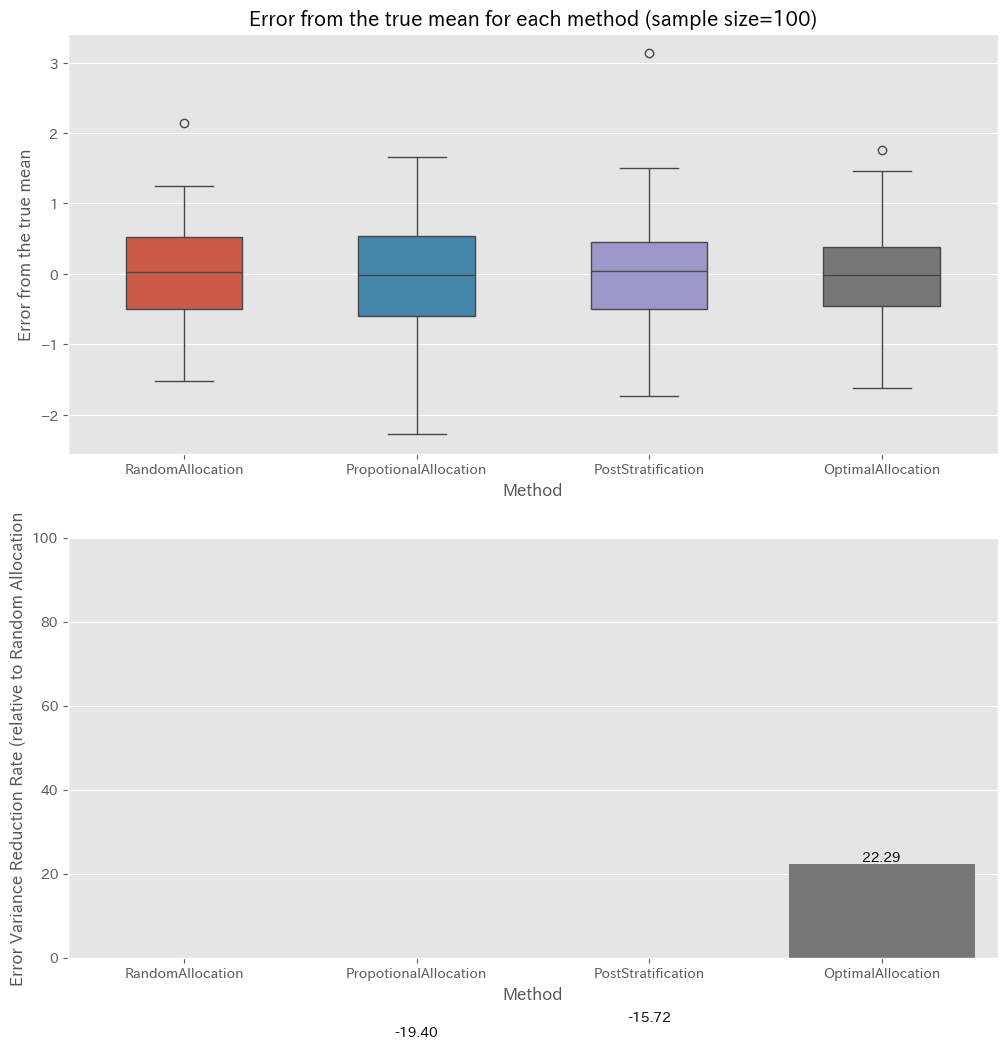

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

axes: list[plt.Axes]
fig, axes = plt.subplots(2, 1, figsize=(12, 6 * 2))

# 箱ひげ図で誤差の分布を比較
y_hat_df = pd.DataFrame(y_hats)
y_hat_df["error"] = (
    y_hat_df["y_hat"] - y.mean()
)  # 真の平均からの誤差をerrorカラムに追加
sns.boxplot(
    data=y_hat_df,
    y="error",
    x="policy",
    hue="policy",
    ax=axes[0],
    linewidth=1,
    width=0.5,
)
axes[0].set_title(
    "Error from the true mean for each method (sample size={})".format(N_SAMPLES)
)
axes[0].set_ylabel("Error from the true mean")
axes[0].set_xlabel("Method")

# 棒グラフでRandomAllocationに対する誤差分散削減率を比較
# random_allocationの誤差分散
random_allocation_std = y_hat_df[y_hat_df["policy"] == "RandomAllocation"][
    "error"
].var()
# random_allocation以外の誤差分散
non_random_allocation_std = (
    y_hat_df[y_hat_df["policy"] != "RandomAllocation"].groupby("policy")["error"].var()
)
reduction_rate = (
    1 - non_random_allocation_std / random_allocation_std
) * 100  # 削減率 (%)
## policyの順番をpoliciesの順番に調整
reduction_rate = reduction_rate.reindex(
    [policy.__class__.__name__ for policy in policies]
)
sns.barplot(
    x=reduction_rate.index,
    y=reduction_rate.values,
    ax=axes[1],
    hue=reduction_rate.index,
)
# 棒グラフの上に値を表示
for i, v in enumerate(reduction_rate.values):
    axes[1].text(i, v, f"{v:.2f}", ha="center", va="bottom")
axes[1].set_ylabel("Error Variance Reduction Rate (relative to Random Allocation")
axes[1].set_xlabel("Method")
axes[1].set_ylim(0, 100)